In [1]:
# import plotly.io as pio
# pio.orca.status

In [2]:
# %%time
# import plotly.io as pio
# from IPython.display import SVG, display
# img_bytes = pio.to_image(fig, format="svg")
# display(SVG(img_bytes))

In [3]:
# %%time
# import plotly.io as pio
# from IPython.display import Image, display
# img_bytes = pio.to_image(fig, format="png")
# display(Image(img_bytes))

# OUTLINE:
GETTING DATA  
EDA (TREND, SEASONALITY) -> the Dickey–Fuller test-> STATIONARITY  
DATA ENGINEERING, PREPROCESING  
MODELING (ARIMA)  
FORECAST, ERRORS

In [4]:
%matplotlib inline

In [5]:
# import libraries
# general:
import pickle
import numpy as np
import pandas as pd
import itertools
from math import ceil
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# models:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR

# metrics:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


TIME SERIES:

univariate TS is a sequence of measurments of the SAME variable collected over time

data in TS not necessarly independent and not necessarly identically distributed

the ordering matters

***
***
# PART_1
***
***

GETTING DATA FROM IMF

https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/USA/WEOWORLD

IMF DATA MAPPER:  
https://www.imf.org/external/datamapper/datasets

DATASETS:  
https://www.imf.org/external/pubs/ft/weo/2019/01/weodata/index.aspx


In [6]:
# import data about world GDP and GDP GROWTH
data= pd.read_csv('data/world_data.xls', sep= '\t', index_col= 0, header= None)

In [7]:
# transpose and delete columns
data = data.T.iloc[4:-1, 0:3]

# rename columns
data.columns= ['YEAR', 'WORLD_GROWTH', 'WORLD_GDP']

# chage data type from string --> float
data.WORLD_GDP= data.WORLD_GDP.str.replace(',', '')
data= data.astype('float')

# change data type to datetime and set new index
data['YEAR']= pd.to_datetime(data.YEAR, format= '%Y')
data.set_index(data['YEAR'], drop= True, inplace= True)
data= data.drop(['YEAR'], axis= 1)

In [8]:
# split data on actual and predicted
data_train= data.iloc[:-6, :]
data_test= data.iloc[-6:, :]

In [9]:
# create separate series
world_growth_train= data_train.WORLD_GROWTH
world_gdp_train= data_train.WORLD_GDP

In [10]:
# save every series as a pickle fle
with open ('world_growth_train.pickle', 'wb') as file:
    pickle.dump(world_growth_train, file, pickle.HIGHEST_PROTOCOL)
    
with open ('world_gdp_train.pickle', 'wb') as file:
    pickle.dump(world_gdp_train, file, pickle.HIGHEST_PROTOCOL)

In [11]:
# def get_clean (file_name):
#     data= pd.read_csv(file_name, sep= '\t', index_col= 0, header= None)

REPEAT FOR US

In [12]:
# import data about world GDP and GDP GROWTH
data= pd.read_csv('data/us_data.xls', sep= '\t', index_col= 0, header= None)

In [13]:
# transpose and delete columns
data = data.T.iloc[4:-1, 0:3]

# rename columns
data.columns= ['YEAR', 'US_GROWTH', 'US_GDP']

# chage data type from string --> float
data.US_GDP= data.US_GDP.str.replace(',', '')
data= data.astype('float')

# change data type to datetime and set new index
data['YEAR']= pd.to_datetime(data.YEAR, format= '%Y')
data.set_index(data['YEAR'], drop= True, inplace= True)
data= data.drop(['YEAR'], axis= 1)

In [14]:
# split data on actual and predicted
data_train= data.iloc[:-6, :]
data_test= data.iloc[-6:, :]

# create separate series
us_growth_train= data_train.US_GROWTH
us_gdp_train= data_train.US_GDP

# save every series as a pickle fle
with open ('us_growth_train.pickle', 'wb') as file:
    pickle.dump(us_growth_train, file, pickle.HIGHEST_PROTOCOL)
    
with open ('us_gdp_train.pickle', 'wb') as file:
    pickle.dump(us_gdp_train, file, pickle.HIGHEST_PROTOCOL)

OVERALL IMAGES:
GROWTH
GDP

In [15]:
# create a graph using plotly library

layout= go.Layout(yaxis={"title": "annual growth, %"}, xaxis= {'title': 'year'})


fig= go.Figure(layout=layout)

fig.add_trace(go.Scatter(
    x= world_growth_train.index,
    y= world_growth_train,
    name= 'world_growth',
    line_color= 'deepskyblue',
    opacity= .8)
             )
fig.add_trace(go.Scatter(
    x=us_growth_train.index,
    y= us_growth_train, 
    name= 'us_growth',
    line_color= 'red',
    opacity= .8)
             )
layout= go.Layout(showlegend= True)
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

fig.update_layout(title_text= 'WORLD vs US GROWTH', xaxis_rangeslider_visible=True)
fig.write_image('images/fig1.png')

fig.show()
# img_bytes = pio.to_image(fig, format="svg")
# display(Image(img_bytes))

In [16]:
# create a graph for GDP using plotly library 
layout= go.Layout(yaxis={"title": "billions, US dollars"}, xaxis= {'title': 'year'})

fig= go.Figure(layout= layout)

fig.add_trace(go.Scatter(
    x= world_gdp_train.index,
    y= world_gdp_train,
    name= 'world_gdp',
    line_color= 'deepskyblue',
    opacity= .8)
             )
fig.add_trace(go.Scatter(
    x=us_gdp_train.index,
    y= us_gdp_train, 
    name= 'us_gdp',
    line_color= 'red',
    opacity= .8)
             )
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

fig.update_layout(title_text= 'WORLD vs US GDP', xaxis_rangeslider_visible=True)

fig.show()

In [17]:
# WORLD ONLY
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= world_growth_train.index,
               y= world_growth_train,
               name="yaxis data"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= world_gdp_train.index,
               y= world_gdp_train,
               name="yaxis2 data"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Double Y Axis Example", xaxis_rangeslider_visible=True
)

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="growth, %", secondary_y=False)
fig.update_yaxes(title_text="billions, US dollars", secondary_y=True)

fig.show()

***
***
PART_2
***
***

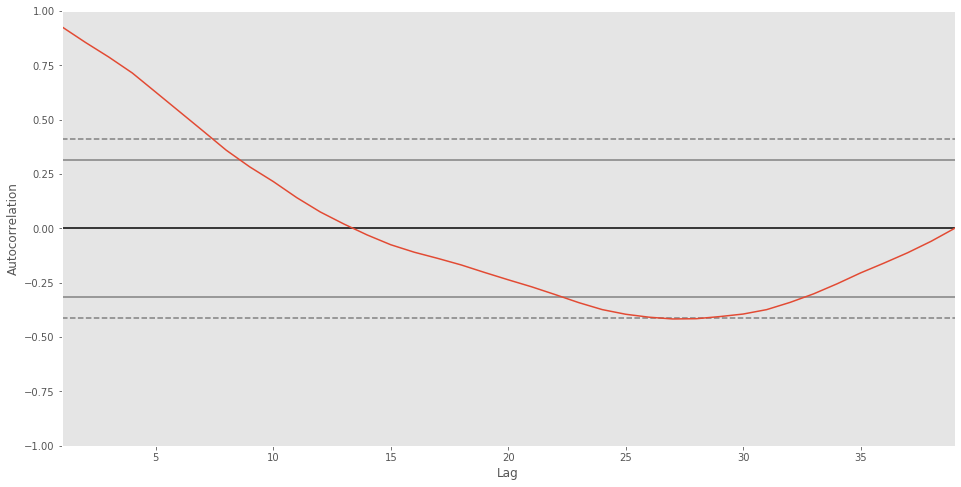

In [18]:
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(world_gdp_train);

In [19]:
#rolling statistics
# pandas rolling (window=, center= ).mean()
# pandas rolling (window=, center= ).std()

In [119]:
#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [118]:
#the dickey-fuller test
test= adfuller(us_gdp_train)
test

(2.5441359782077444,
 0.9990627146143649,
 2,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 382.1950560377017)

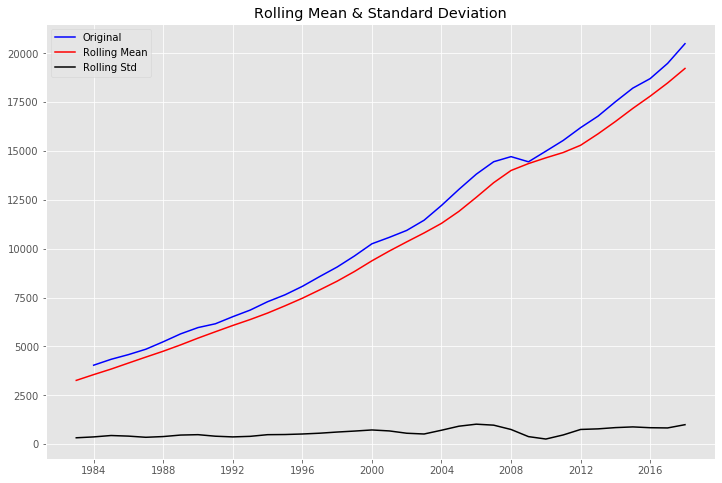

Results of Dickey-Fuller Test:
Test Statistic                  2.544136
p-value                         0.999063
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [120]:
test_stationarity(us_gdp_train, 4)

***
***
PART_3
***
***

In [21]:
# log_transformation
# subtract rolling mean
# differecing
# pandas diff(periods= 1)
# decomposition
# decompostion= seasonal_decompose()
# trend= decomposition.trend
# seasonal= decomposition.seasonal
# residual= decomposition.resid

***
***
PART_4
***
***

PART_4.1 SAMPLE AUTOCORRELATION FUNCTION (ACF)

A sample autocorrelation function (ACF)for a series gives correlations between the series $x_t$ and lagged values of the series for lags 1, 2, 3, and so on. The lagged values can be written as $x_{t-1}, x_{t-2}, x_{t-3}$, and so on. The ACF gives correlations between $x_t$ and $x_{t-1}$, $x_t$ and $x_{t-2}$, and so on.

The ACF can be used to identify possible structure of time series data.

In [22]:
#?np.arange

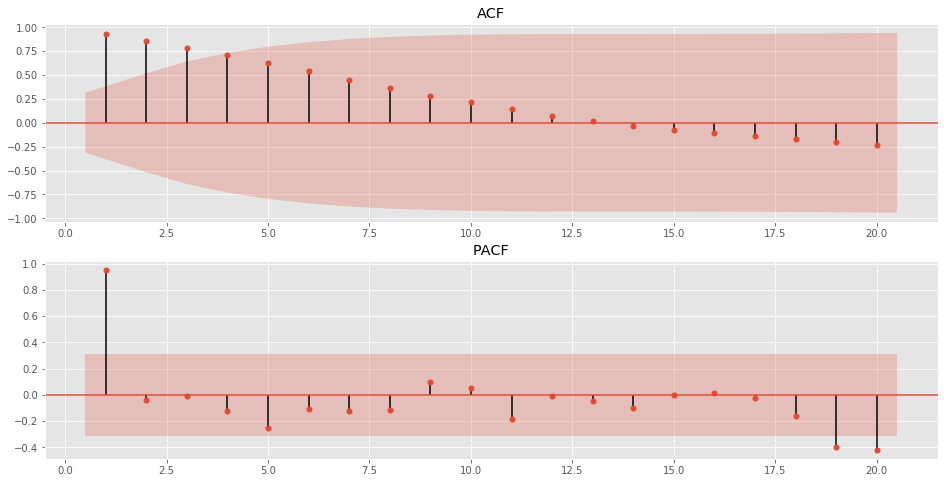

In [23]:
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(world_gdp_train, lags=20, title='ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(world_gdp_train, lags=20, title= 'PACF', zero= False, ax=ax2)

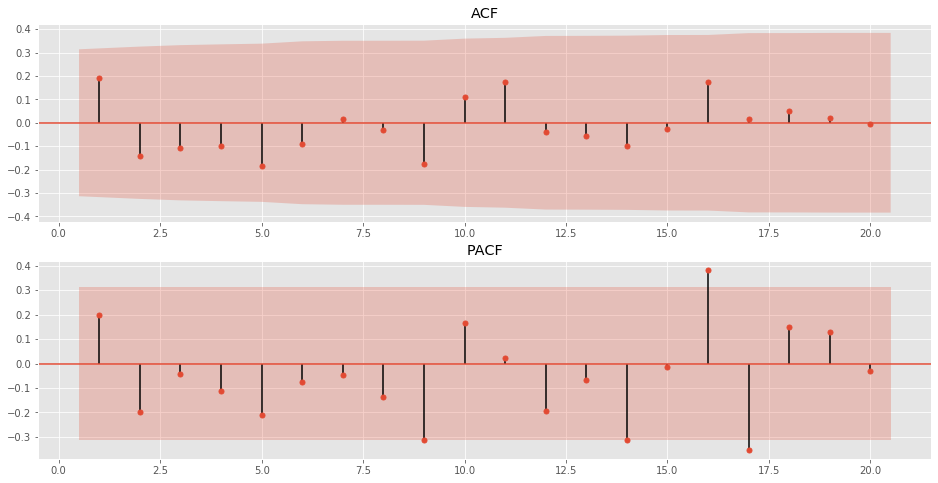

In [24]:
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(world_growth_train, lags=20, title= 'ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(world_growth_train, lags=20, title= 'PACF', zero= False, ax=ax2)

In [25]:
def explore_first_difference(Series, n):
    '''
    Input: pandas.Series, number of differnces
    Output: 
    '''
    diff= Series.diff(n)
    
    fig = plt.figure(figsize=(16,8))
    
    # plot difference
    ax1= fig.add_subplot(211)
    plt.plot(diff, ax= ax1)
    
    #plot the ACF
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_acf(diff, lags=18, ax=ax2)
    
    #plot the PACF
    ax3 = fig.add_subplot(213)
    fig = sm.graphics.tsa.plot_pacf(diff, lags=18, ax=ax3)

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



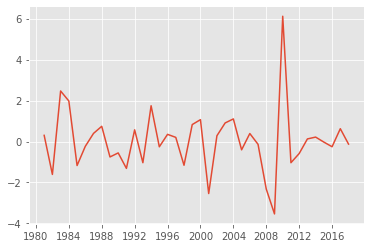

In [26]:
first_diff= world_growth_train.diff(1)
plt.plot(first_diff)

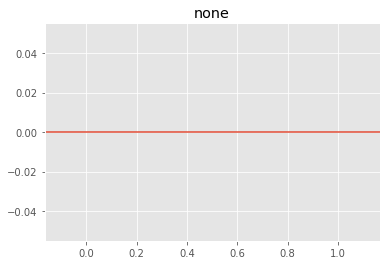

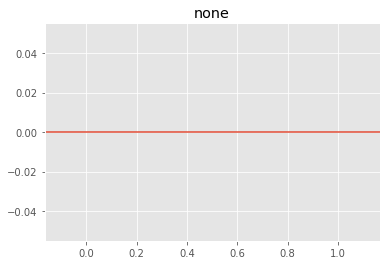

In [27]:
sm.graphics.tsa.plot_acf(first_diff, title='none')

In [28]:
#explore_first_difference(world_gdp_train, 1)

One of the simplest ARIMA type models is a model in which we use a linear model to predict the value at the present time using the value at the previous time. This is called __an AR(1) model__, standing for autoregressive model of order 1. The order of the model indicates how many previous times we use to predict the present time.

In [29]:
# create a function which outputs a dataframe with lags
def shift_n (Series, n):
    '''
    Input: pandas.Series, number of lags
    Ouput: dataFrame
    '''
    data= pd.DataFrame(Series)
    data['lag']= data.shift(n)
    return data

In [30]:
data= shift_n(world_gdp_train, 1)

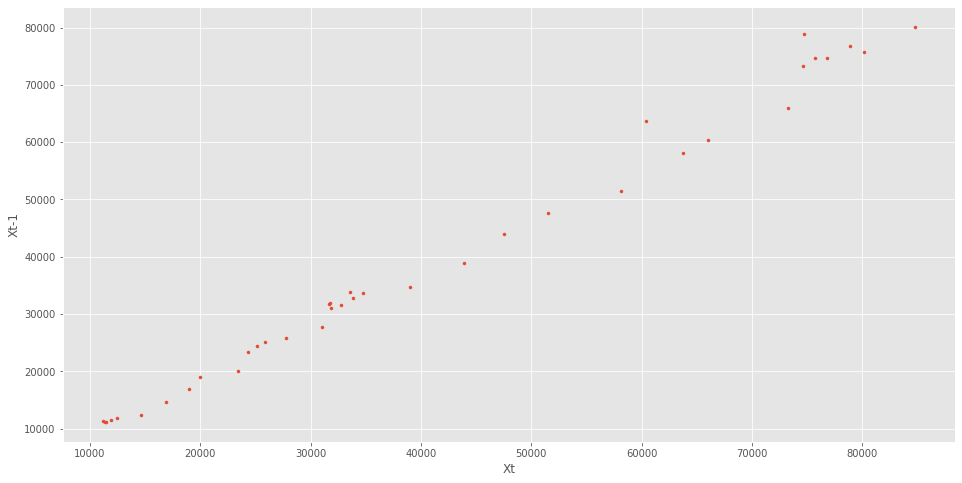

In [31]:
plt.figure(figsize= (16, 8))
plt.scatter(data.WORLD_GDP, data.lag, marker= '.')
plt.xlabel('Xt')
plt.ylabel('Xt-1')
plt.show()

the same with plotly

In [32]:
dat= go.Scatter(x= data.WORLD_GDP, y= data.lag,
                 mode= 'markers', marker=dict(size=list(range(10, 100, 10))*1000, color=[0, 1, 2, 3])
                 )

fig= go.Figure(data= dat)

fig.show()

the AR(1) model is written:
$x_t = \delta + \phi_1x_t-1 + \epsilon_t$

Assumptions:
- $\epsilon_t \stackrel{\text{iid}}{\sim} N(0, \sigma^2_t)$, meaning that the errors are independently distributed with a normal distribution that has mean 0 and constant variance;
- Properties of the errors $\epsilon_t$ are independent of $x$.

In [34]:
# create train/test split
train= data.WORLD_GDP.iloc[: ceil(.8*len(data))]
test= data.WORLD_GDP.iloc[len(train) : ]

In [35]:
# train a model
model= AR(train)
model_fitted= model.fit()

print(f'a lag value chose is {model_fitted.k_ar}')
print(f'the coefs are:\n {model_fitted.params}' )

a lag value chose is 9
the coefs are:
 const          -198.082576
L1.WORLD_GDP      1.004984
L2.WORLD_GDP     -0.234515
L3.WORLD_GDP      0.554258
L4.WORLD_GDP      0.117126
L5.WORLD_GDP     -0.628361
L6.WORLD_GDP     -0.482215
L7.WORLD_GDP      0.783994
L8.WORLD_GDP     -0.106731
L9.WORLD_GDP      0.104666
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<Figure size 1152x576 with 0 Axes>

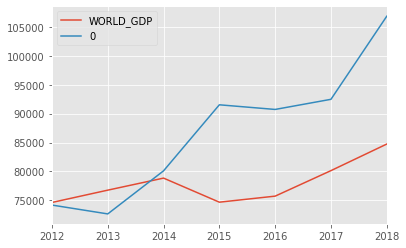

In [36]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train), 
    end=len(train) + len(test)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [test,
    predictions], axis=1)

#plot the two values
plt.figure(figsize= (16, 8))
compare_df.plot()
plt.show()

In [37]:
print(f'r2 score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')

r2 score: -13.661876624197705
RMSE: 12914.779663027884


GROWTH

a lag value chose is 9
the coefs are:
 const              9.610817
L1.WORLD_GROWTH   -0.042274
L2.WORLD_GROWTH   -0.245613
L3.WORLD_GROWTH   -0.361858
L4.WORLD_GROWTH   -0.463648
L5.WORLD_GROWTH   -0.495068
L6.WORLD_GROWTH    0.131543
L7.WORLD_GROWTH   -0.278283
L8.WORLD_GROWTH    0.159511
L9.WORLD_GROWTH   -0.646063
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<Figure size 1152x576 with 0 Axes>

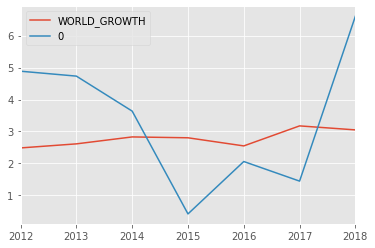

r2 score: -80.13538470438732
RMSE: 2.151425410397956


In [38]:
# create train/test split
number= len(world_growth_train)
train= world_growth_train.iloc[: ceil(.8*number)]
test= world_growth_train.iloc[len(train):]

# train a model
model= AR(train)
model_fitted= model.fit()

print(f'a lag value chose is {model_fitted.k_ar}')
print(f'the coefs are:\n {model_fitted.params}' )

# make predictions 
predictions = model_fitted.predict(
    start=len(train), 
    end=len(train) + len(test)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [test,
    predictions], axis=1)

#plot the two values
plt.figure(figsize= (16, 8))
compare_df.plot()
plt.show()

print(f'r2 score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')

# RESIDUAL ANALYSIS#

In [40]:
# mod= ARIMA(data_train.WORLD_GROWTH, (1, 1, 0))
# res= mod.fit()

In [41]:
# res.summary()

In [42]:
# data_train['predict'] = res.predict(start= 32, end= 39, dynamic= False)  
# data_train[['WORLD_GROWTH', 'predict']].plot(figsize=(16, 12)) 

In [43]:
#world_growth_train

***
# MODEL SELECTION
***
***

In [88]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [93]:
# Run a grid with pdq parameters calculated above and get the best AIC value

def best_param(Series):
    aic= []
    bic= []
    for comb in pdq:
        try:
            model= sm.tsa.statespace.SARIMAX(Series,
                                            order= comb,
                                            enforce_stationarity= False,
                                            enforce_invertibility= False)

            output= model.fit()
            aic.append([comb, output.aic])
            bic.append([comb, output.bic])
            print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
            print('ARIMA {} : BIC Calculated ={}'.format(comb, output.bic))
        except:
            continue
   
    # Find the parameters with minimal AIC value.

    aicFrame = pd.DataFrame(aic, columns=['COMBINATION', 'AIC'])
    bicFrame = pd.DataFrame(bic, columns=['COMBINATION', 'BIC'])
    AIC= aicFrame.loc[aicFrame['AIC'].idxmin()]
    BIC= bicFrame.loc[bicFrame['BIC'].idxmin()]
    return AIC, BIC

In [94]:
best_param(us_gdp_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =821.5562544881302
ARIMA (0, 0, 0) : BIC Calculated =823.1938406478566
ARIMA (0, 0, 1) : AIC Calculated =875.8357170376365
ARIMA (0, 0, 1) : BIC Calculated =879.0575528629249
ARIMA (0, 0, 2) : AIC Calculated =842.7313573621585
ARIMA (0, 0, 2) : BIC Calculated =847.4819141775268
ARIMA (0, 1, 0) : AIC Calculated =569.9437258822463
ARIMA (0, 1, 0) : BIC Calculated =571.5546437948906
ARIMA (0, 1, 1) : AIC Calculated =528.4209300773188
ARIMA (0, 1, 1) : BIC Calculated =531.587967954231
ARIMA (0, 1, 2) : AIC Calculated =498.2782134760084
ARIMA (0, 1, 2) : BIC Calculated =502.94425766047664
ARIMA (0, 2, 0) : AIC Calculated =490.2026473622819
ARIMA (0, 2, 0) : BIC Calculated =491.786166300738
ARIMA (0, 2, 1) : AIC Calculated =478.4746489450628
ARIMA (0, 2, 1) : BIC Calculated =481.58534506804165
ARIMA (0, 2, 2) : AIC Calculated =462.1405159534188
ARIMA (0, 2, 2) : BIC Calculated =466.7195975272673
ARIMA (1, 0, 0) : AIC Calculated =518.721728952575
ARIMA (1, 0, 

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so

ARIMA (1, 1, 1) : AIC Calculated =490.089289342641
ARIMA (1, 1, 1) : BIC Calculated =494.8398461580093
ARIMA (1, 1, 2) : AIC Calculated =472.98212550557156
ARIMA (1, 1, 2) : BIC Calculated =479.2035177515292
ARIMA (1, 2, 0) : AIC Calculated =491.77746111634565
ARIMA (1, 2, 0) : BIC Calculated =494.94449899325787
ARIMA (1, 2, 1) : AIC Calculated =476.60817499532226
ARIMA (1, 2, 1) : BIC Calculated =481.2742191797905


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (1, 2, 2) : AIC Calculated =463.8532967525872
ARIMA (1, 2, 2) : BIC Calculated =469.95873885105186
ARIMA (2, 0, 0) : AIC Calculated =497.429455616674
ARIMA (2, 0, 0) : BIC Calculated =502.2622093546066
ARIMA (2, 0, 1) : AIC Calculated =498.28527292835906
ARIMA (2, 0, 1) : BIC Calculated =504.72894457893597
ARIMA (2, 0, 2) : AIC Calculated =487.6740495031502
ARIMA (2, 0, 2) : BIC Calculated =495.5916441954307


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 1, 0) : AIC Calculated =493.66691836582925
ARIMA (2, 1, 0) : BIC Calculated =498.4174751811976
ARIMA (2, 1, 1) : AIC Calculated =489.33611738065537
ARIMA (2, 1, 1) : BIC Calculated =495.6701931344798
ARIMA (2, 1, 2) : AIC Calculated =474.8621095531699
ARIMA (2, 1, 2) : BIC Calculated =482.638849860617
ARIMA (2, 2, 0) : AIC Calculated =478.8987734627529
ARIMA (2, 2, 0) : BIC Calculated =483.56481764722116


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 2, 1) : AIC Calculated =475.67521637698354
ARIMA (2, 2, 1) : BIC Calculated =481.8966086229412
ARIMA (2, 2, 2) : AIC Calculated =465.2008156689025
ARIMA (2, 2, 2) : BIC Calculated =472.83261829198335


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



(COMBINATION    (0, 2, 2)
 AIC              462.141
 Name: 8, dtype: object, COMBINATION    (0, 2, 2)
 BIC               466.72
 Name: 8, dtype: object)

In [95]:
# plug the optimal parameter values into a new SARIMAX model.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(0, 2, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model and print results

output = ARIMA_MODEL.fit()

print(output.summary())


                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -228.070
Date:                Thu, 25 Jul 2019   AIC                            462.141
Time:                        09:29:45   BIC                            466.720
Sample:                    01-01-1980   HQIC                           463.702
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3821      0.125     -3.048      0.002      -0.628      -0.136
ma.L2         -0.3664      0.197     -1.858      0.063      -0.753       0.020
sigma2      3.896e+04   9139.389      4.263      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



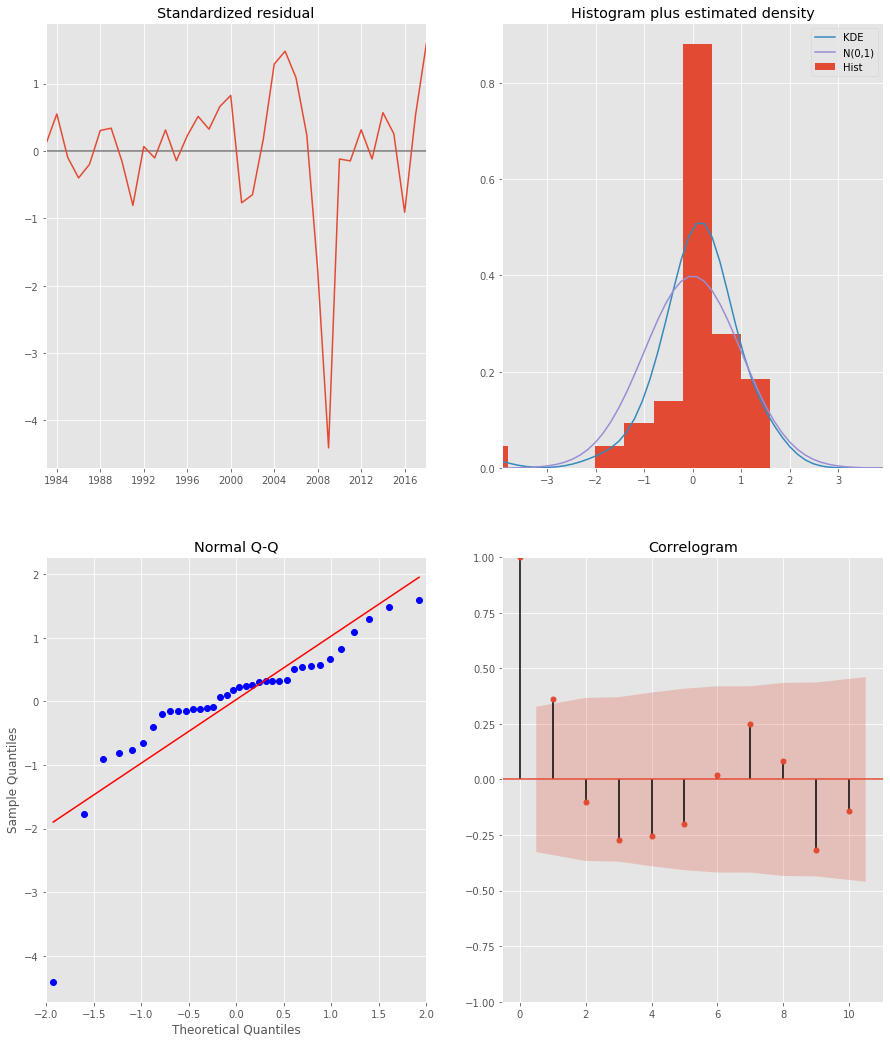

In [48]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [49]:
# Get predictions starting from 01-01-2011 and calculate confidence intervals.

pred = output.get_prediction(start='2011-01-01', dynamic=False)
pred_conf = pred.conf_int()

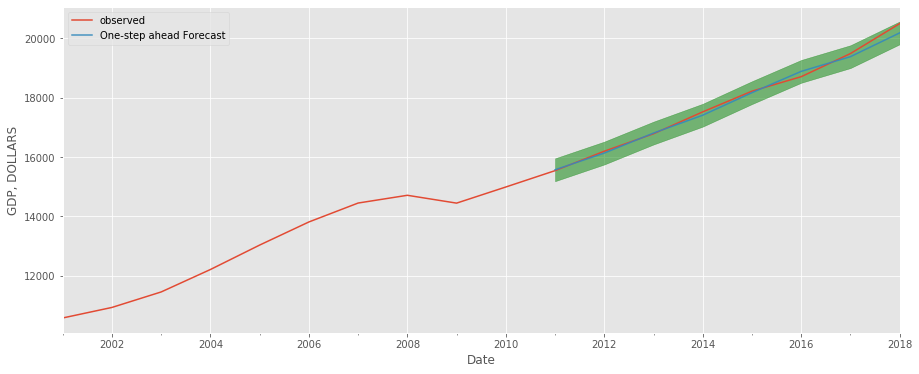

In [50]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = us_gdp_train['2001':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range bfor confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')
plt.legend()

plt.show()

In [51]:
# Get the Real and predicted values
GDP_forecasted = pred.predicted_mean
GDP_truth= us_gdp_train['2011-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 20064.54


# DYNAMIC

In [52]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

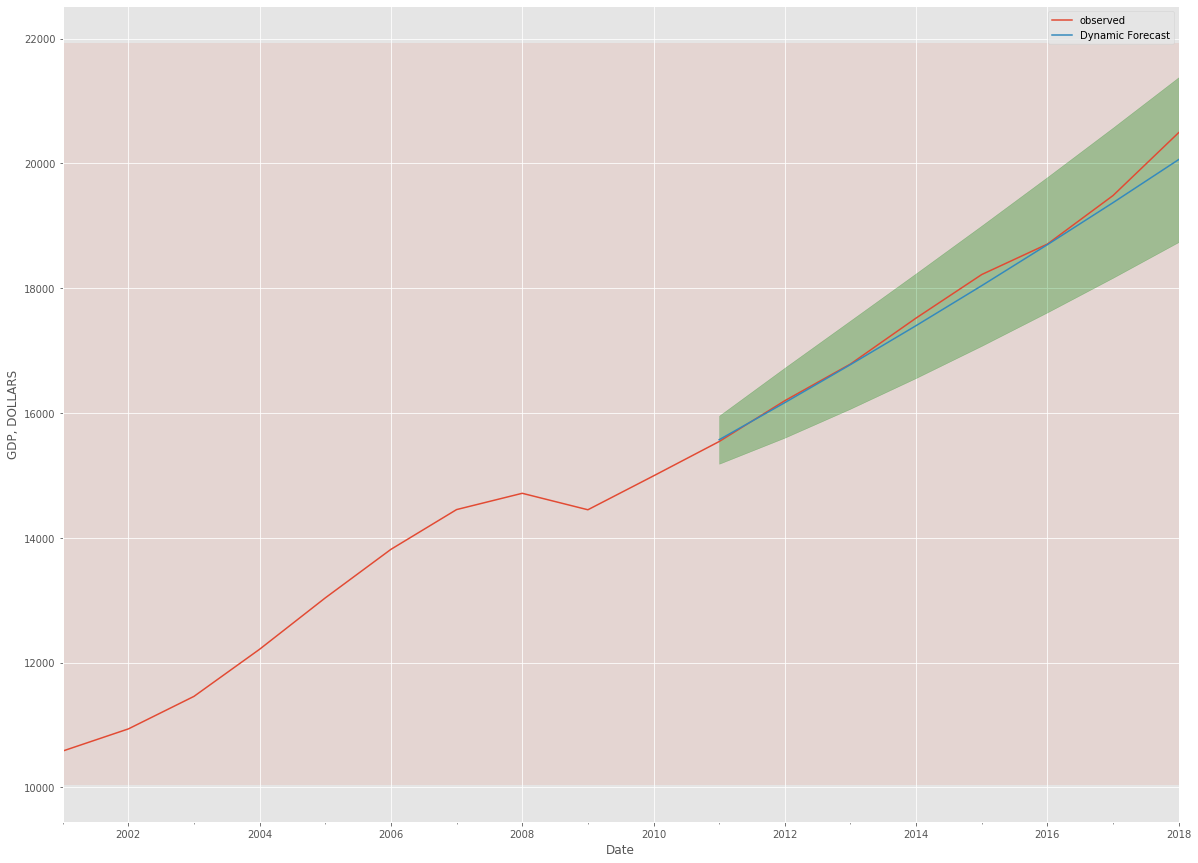

In [53]:
# Plot the dynamic forecast with confidence intervals.

ax = us_gdp_train['2001':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2001-01-01'), GDP_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')

plt.legend()
plt.show()

In [54]:
# Extract the predicted and true values of our time series
GDP_forecasted = pred_dynamic.predicted_mean
GDP_truth = us_gdp_train['2011-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 31024.44


In [55]:
# Get forecast 10 steps ahead in future
prediction = output.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

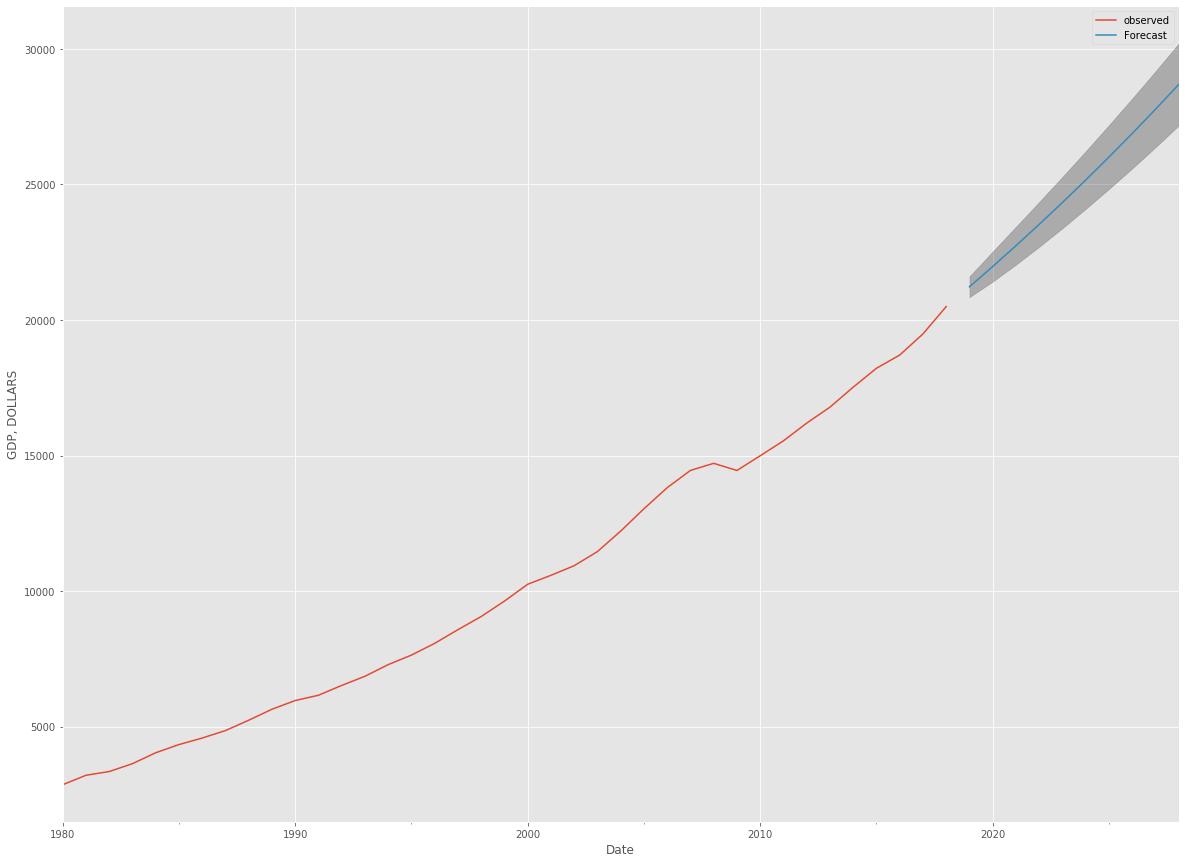

In [56]:
# Plot future predictions with confidence intervals

ax = us_gdp_train.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')

plt.legend()
plt.show()

# PREDICTIONS

In [112]:
def analyse_series (Series, p, d, q, year):
    '''
    Input: Time Series, parametrs, starting year
    Output:
    '''
    # plug the optimal parameter values into a new SARIMAX model.
    model= sm.tsa.statespace.SARIMAX(Series,
                                order=(p, d, q),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    # fit the model and print results

    output = model.fit()

    print(output.summary())
    
    # Use plot_diagnostics with results calculated above.
    output.plot_diagnostics(figsize=(18, 18))
    plt.show()
    
    # Get predictions starting from 01-01-year and calculate confidence intervals.

    prediction = output.get_prediction(start='{}-01-01'.format(year), dynamic=False)
    int_ = prediction.conf_int()
    
    # Plot real vs predicted values along with confidence interval

    rcParams['figure.figsize'] = 16, 8

    #Plot observed values
    ax = Series['{}'.format(year):].plot(label='observed')

    #Plot predicted values
    prediction.predicted_mean.plot(ax=ax, label='one-step ahead Forecast', alpha=.5)

    #Plot the range for confidence intervals
    ax.fill_between(int_.index,
                int_.iloc[:, 0],
                int_.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
    ax.set_xlabel('date')
    ax.set_ylabel('prediction')
    plt.legend()

    plt.show()
    
    # Extract the predicted and true values of our time series
    forecast= prediction.predicted_mean
    true= Series['{}-01-01'.format(year):]

    # Compute the mean squared error and root mean squared error
    mse = ((forecast - true) ** 2).mean()
    print('The Mean Squared Error is: {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error is: {}'.format(round(np.sqrt(mse), 2)))

# PREDICT US_GDP

In [96]:
best_param(us_gdp_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =821.5562544881302
ARIMA (0, 0, 0) : BIC Calculated =823.1938406478566
ARIMA (0, 0, 1) : AIC Calculated =875.8357170376365
ARIMA (0, 0, 1) : BIC Calculated =879.0575528629249
ARIMA (0, 0, 2) : AIC Calculated =842.7313573621585
ARIMA (0, 0, 2) : BIC Calculated =847.4819141775268
ARIMA (0, 1, 0) : AIC Calculated =569.9437258822463
ARIMA (0, 1, 0) : BIC Calculated =571.5546437948906
ARIMA (0, 1, 1) : AIC Calculated =528.4209300773188
ARIMA (0, 1, 1) : BIC Calculated =531.587967954231
ARIMA (0, 1, 2) : AIC Calculated =498.2782134760084
ARIMA (0, 1, 2) : BIC Calculated =502.94425766047664
ARIMA (0, 2, 0) : AIC Calculated =490.2026473622819
ARIMA (0, 2, 0) : BIC Calculated =491.786166300738
ARIMA (0, 2, 1) : AIC Calculated =478.4746489450628
ARIMA (0, 2, 1) : BIC Calculated =481.58534506804165
ARIMA (0, 2, 2) : AIC Calculated =462.1405159534188
ARIMA (0, 2, 2) : BIC Calculated =466.7195975272673
ARIMA (1, 0, 0) : AIC Calculated =518.721728952575
ARIMA (1, 0, 

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so

ARIMA (1, 1, 1) : AIC Calculated =490.089289342641
ARIMA (1, 1, 1) : BIC Calculated =494.8398461580093
ARIMA (1, 1, 2) : AIC Calculated =472.98212550557156
ARIMA (1, 1, 2) : BIC Calculated =479.2035177515292
ARIMA (1, 2, 0) : AIC Calculated =491.77746111634565
ARIMA (1, 2, 0) : BIC Calculated =494.94449899325787
ARIMA (1, 2, 1) : AIC Calculated =476.60817499532226
ARIMA (1, 2, 1) : BIC Calculated =481.2742191797905


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (1, 2, 2) : AIC Calculated =463.8532967525872
ARIMA (1, 2, 2) : BIC Calculated =469.95873885105186
ARIMA (2, 0, 0) : AIC Calculated =497.429455616674
ARIMA (2, 0, 0) : BIC Calculated =502.2622093546066
ARIMA (2, 0, 1) : AIC Calculated =498.28527292835906
ARIMA (2, 0, 1) : BIC Calculated =504.72894457893597


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 0, 2) : AIC Calculated =487.6740495031502
ARIMA (2, 0, 2) : BIC Calculated =495.5916441954307
ARIMA (2, 1, 0) : AIC Calculated =493.66691836582925
ARIMA (2, 1, 0) : BIC Calculated =498.4174751811976
ARIMA (2, 1, 1) : AIC Calculated =489.33611738065537
ARIMA (2, 1, 1) : BIC Calculated =495.6701931344798
ARIMA (2, 1, 2) : AIC Calculated =474.8621095531699
ARIMA (2, 1, 2) : BIC Calculated =482.638849860617


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 2, 0) : AIC Calculated =478.8987734627529
ARIMA (2, 2, 0) : BIC Calculated =483.56481764722116
ARIMA (2, 2, 1) : AIC Calculated =475.67521637698354
ARIMA (2, 2, 1) : BIC Calculated =481.8966086229412
ARIMA (2, 2, 2) : AIC Calculated =465.2008156689025
ARIMA (2, 2, 2) : BIC Calculated =472.83261829198335


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



(COMBINATION    (0, 2, 2)
 AIC              462.141
 Name: 8, dtype: object, COMBINATION    (0, 2, 2)
 BIC               466.72
 Name: 8, dtype: object)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -228.070
Date:                Thu, 25 Jul 2019   AIC                            462.141
Time:                        09:44:57   BIC                            466.720
Sample:                    01-01-1980   HQIC                           463.702
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3821      0.125     -3.048      0.002      -0.628      -0.136
ma.L2         -0.3664      0.197     -1.858      0.063      -0.753       0.020
sigma2      3.896e+04   9139.389      4.263      0.0

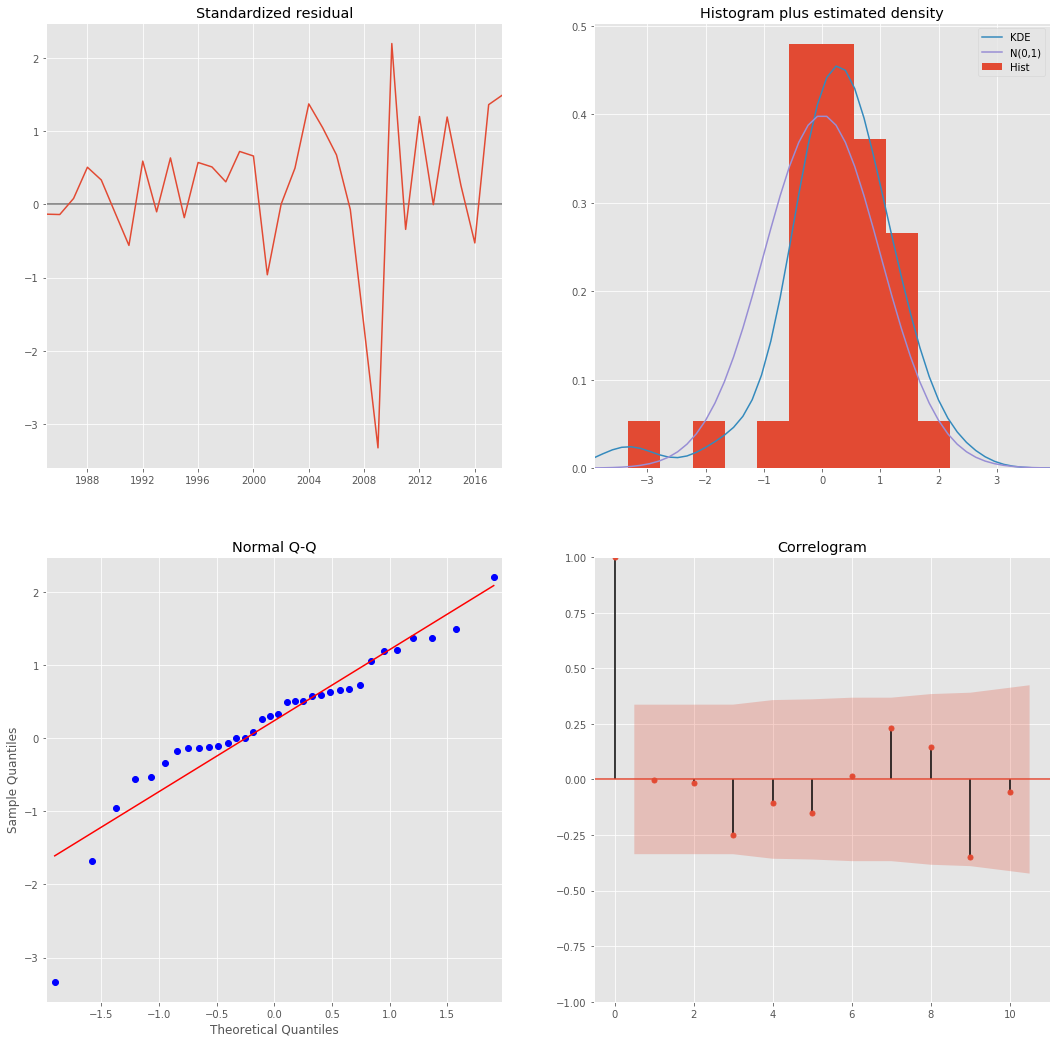

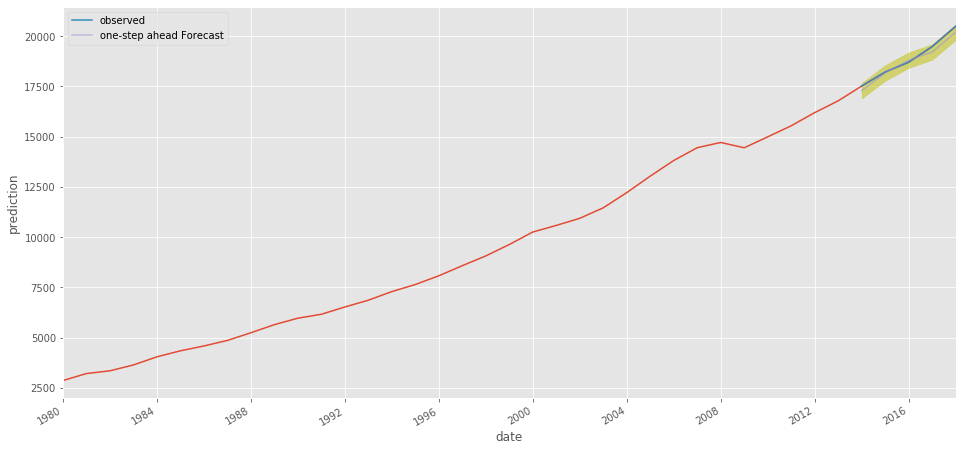

The Mean Squared Error is: 45689.42
The Root Mean Squared Error is: 213.75


In [109]:
# make a prediction using best parametrs
analyse_series(us_gdp_train, 0, 2, 2, 2014)

# PREDICT US_GROWTH

In [100]:
best_param(us_growth_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =199.32914397970922
ARIMA (0, 0, 0) : BIC Calculated =200.9667301394356
ARIMA (0, 0, 1) : AIC Calculated =173.0606319848677
ARIMA (0, 0, 1) : BIC Calculated =176.28246781015616
ARIMA (0, 0, 2) : AIC Calculated =153.06568922089247
ARIMA (0, 0, 2) : BIC Calculated =157.8162460362608
ARIMA (0, 1, 0) : AIC Calculated =160.80315610332013
ARIMA (0, 1, 0) : BIC Calculated =162.41407401596436
ARIMA (0, 1, 1) : AIC Calculated =148.13086573068568
ARIMA (0, 1, 1) : BIC Calculated =151.2979036075979
ARIMA (0, 1, 2) : AIC Calculated =133.79954031869602
ARIMA (0, 1, 2) : BIC Calculated =138.46558450316425
ARIMA (0, 2, 0) : AIC Calculated =188.1415460902471
ARIMA (0, 2, 0) : BIC Calculated =189.7250650287032
ARIMA (0, 2, 1) : AIC Calculated =144.75443560953863
ARIMA (0, 2, 1) : BIC Calculated =147.86513173251745
ARIMA (0, 2, 2) : AIC Calculated =140.31048267453247
ARIMA (0, 2, 2) : BIC Calculated =144.88956424838096
ARIMA (1, 0, 0) : AIC Calculated =164.08320686692227

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (2, 0, 1) : AIC Calculated =153.35259054062576
ARIMA (2, 0, 1) : BIC Calculated =159.79626219120266
ARIMA (2, 0, 2) : AIC Calculated =150.17200010031507
ARIMA (2, 0, 2) : BIC Calculated =158.08959479259562
ARIMA (2, 1, 0) : AIC Calculated =152.73031389386927
ARIMA (2, 1, 0) : BIC Calculated =157.4808707092376
ARIMA (2, 1, 1) : AIC Calculated =147.07659600816137
ARIMA (2, 1, 1) : BIC Calculated =153.4106717619858


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 1, 2) : AIC Calculated =135.45591801625002
ARIMA (2, 1, 2) : BIC Calculated =143.23265832369708
ARIMA (2, 2, 0) : AIC Calculated =158.2312267967205
ARIMA (2, 2, 0) : BIC Calculated =162.89727098118874
ARIMA (2, 2, 1) : AIC Calculated =155.02328918235793
ARIMA (2, 2, 1) : BIC Calculated =161.24468142831557
ARIMA (2, 2, 2) : AIC Calculated =150.14647589086465
ARIMA (2, 2, 2) : BIC Calculated =157.77827851394545


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



(COMBINATION    (0, 1, 2)
 AIC                133.8
 Name: 5, dtype: object, COMBINATION    (0, 1, 2)
 BIC              138.466
 Name: 5, dtype: object)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:              US_GROWTH   No. Observations:                   39
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -63.900
Date:                Thu, 25 Jul 2019   AIC                            133.800
Time:                        09:33:30   BIC                            138.466
Sample:                    01-01-1980   HQIC                           135.410
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4660      0.148     -3.159      0.002      -0.755      -0.177
ma.L2         -0.4213      0.139     -3.024      0.002      -0.694      -0.148
sigma2         2.1860      0.574      3.807      0.0

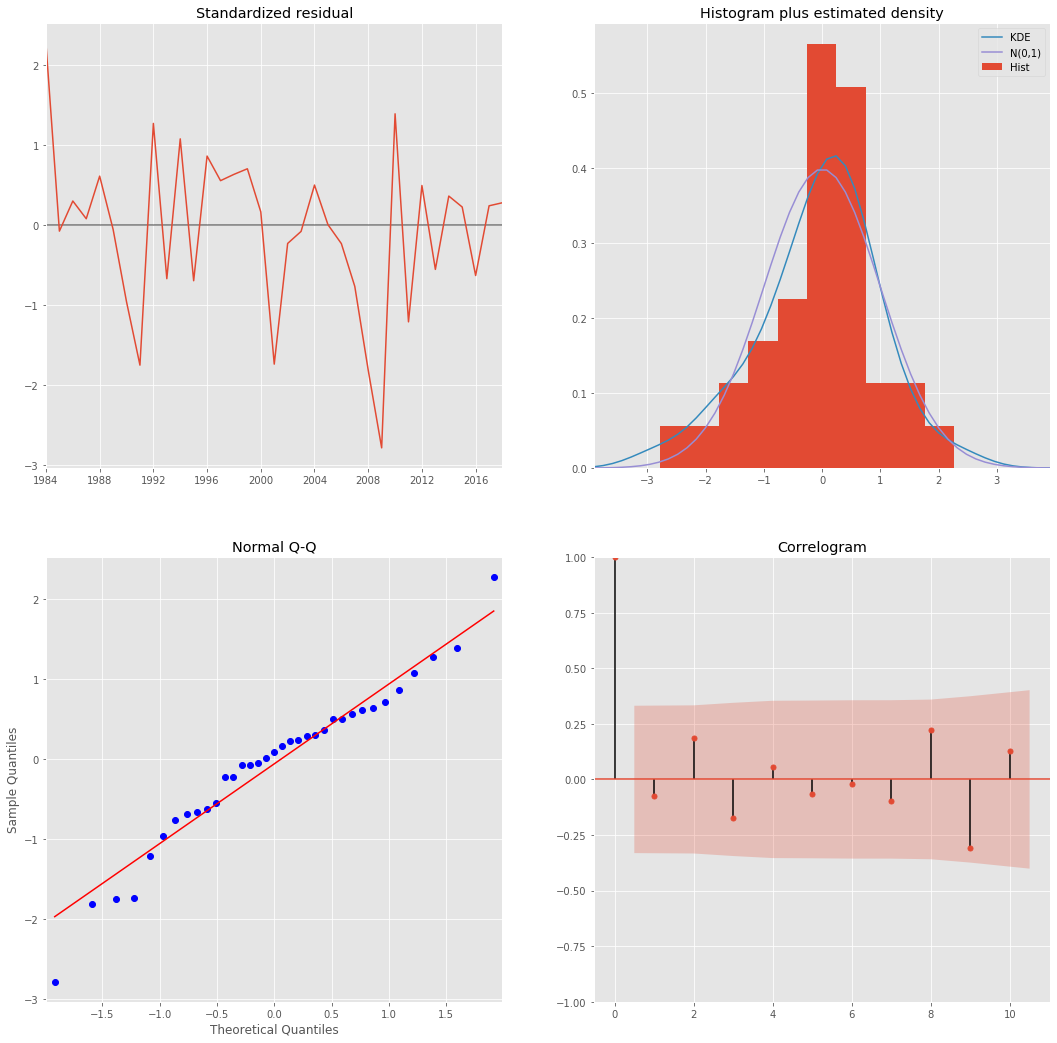

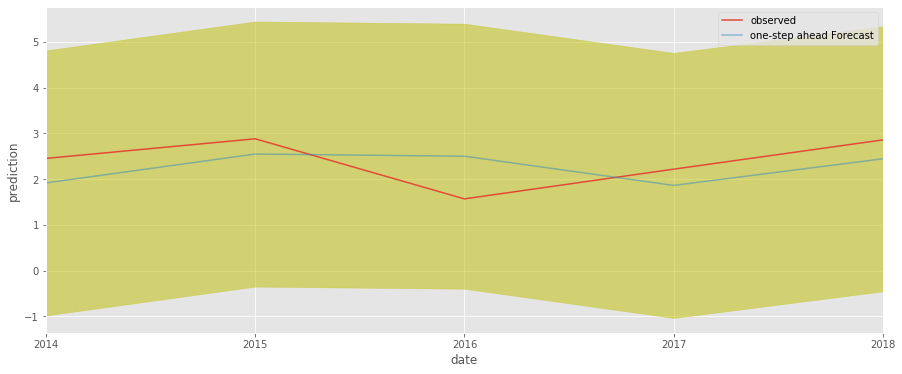

The Mean Squared Error is: 0.31
The Root Mean Squared Error is: 0.56


In [101]:
analyse_series(us_growth_train, 0, 1, 2, 2014)

# PREDICT WORLD_GDP

In [102]:
best_param(world_gdp_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =928.1390318823977
ARIMA (0, 0, 0) : BIC Calculated =929.7766180421241
ARIMA (0, 0, 1) : AIC Calculated =880.9723305356902
ARIMA (0, 0, 1) : BIC Calculated =884.1941663609786
ARIMA (0, 0, 2) : AIC Calculated =857.2450239237735
ARIMA (0, 0, 2) : BIC Calculated =861.9955807391418
ARIMA (0, 1, 0) : AIC Calculated =702.3657451584414
ARIMA (0, 1, 0) : BIC Calculated =703.9766630710857
ARIMA (0, 1, 1) : AIC Calculated =675.183757534699
ARIMA (0, 1, 1) : BIC Calculated =678.3507954116112
ARIMA (0, 1, 2) : AIC Calculated =660.3986660819568
ARIMA (0, 1, 2) : BIC Calculated =665.064710266425
ARIMA (0, 2, 0) : AIC Calculated =681.0689408570591
ARIMA (0, 2, 0) : BIC Calculated =682.6524597955153
ARIMA (0, 2, 1) : AIC Calculated =653.981922924686
ARIMA (0, 2, 1) : BIC Calculated =657.0926190476649
ARIMA (0, 2, 2) : AIC Calculated =633.1387949164689
ARIMA (0, 2, 2) : BIC Calculated =637.7178764903174
ARIMA (1, 0, 0) : AIC Calculated =703.0694123656883
ARIMA (1, 0, 0)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (2, 0, 0) : AIC Calculated =685.9802906534057
ARIMA (2, 0, 0) : BIC Calculated =690.8130443913384
ARIMA (2, 0, 1) : AIC Calculated =685.7668180905407
ARIMA (2, 0, 1) : BIC Calculated =692.2104897411176
ARIMA (2, 0, 2) : AIC Calculated =669.349789488216
ARIMA (2, 0, 2) : BIC Calculated =677.2673841804965
ARIMA (2, 1, 0) : AIC Calculated =676.3929340112732
ARIMA (2, 1, 0) : BIC Calculated =681.1434908266415
ARIMA (2, 1, 1) : AIC Calculated =673.2877144983848
ARIMA (2, 1, 1) : BIC Calculated =679.6217902522093


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so

ARIMA (2, 1, 2) : AIC Calculated =653.6937303720902
ARIMA (2, 1, 2) : BIC Calculated =661.4704706795372
ARIMA (2, 2, 0) : AIC Calculated =651.557338632103
ARIMA (2, 2, 0) : BIC Calculated =656.2233828165712
ARIMA (2, 2, 1) : AIC Calculated =653.2061985769099
ARIMA (2, 2, 1) : BIC Calculated =659.4275908228675
ARIMA (2, 2, 2) : AIC Calculated =635.5853697747737
ARIMA (2, 2, 2) : BIC Calculated =643.2171723978545


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



(COMBINATION    (0, 2, 2)
 AIC              633.139
 Name: 8, dtype: object, COMBINATION    (0, 2, 2)
 BIC              637.718
 Name: 8, dtype: object)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:              WORLD_GDP   No. Observations:                   39
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -313.569
Date:                Thu, 25 Jul 2019   AIC                            633.139
Time:                        09:33:53   BIC                            637.718
Sample:                    01-01-1980   HQIC                           634.700
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5786      0.218     -2.653      0.008      -1.006      -0.151
ma.L2         -0.3711      0.135     -2.741      0.006      -0.636      -0.106
sigma2      5.516e+06   1.55e+06      3.561      0.0

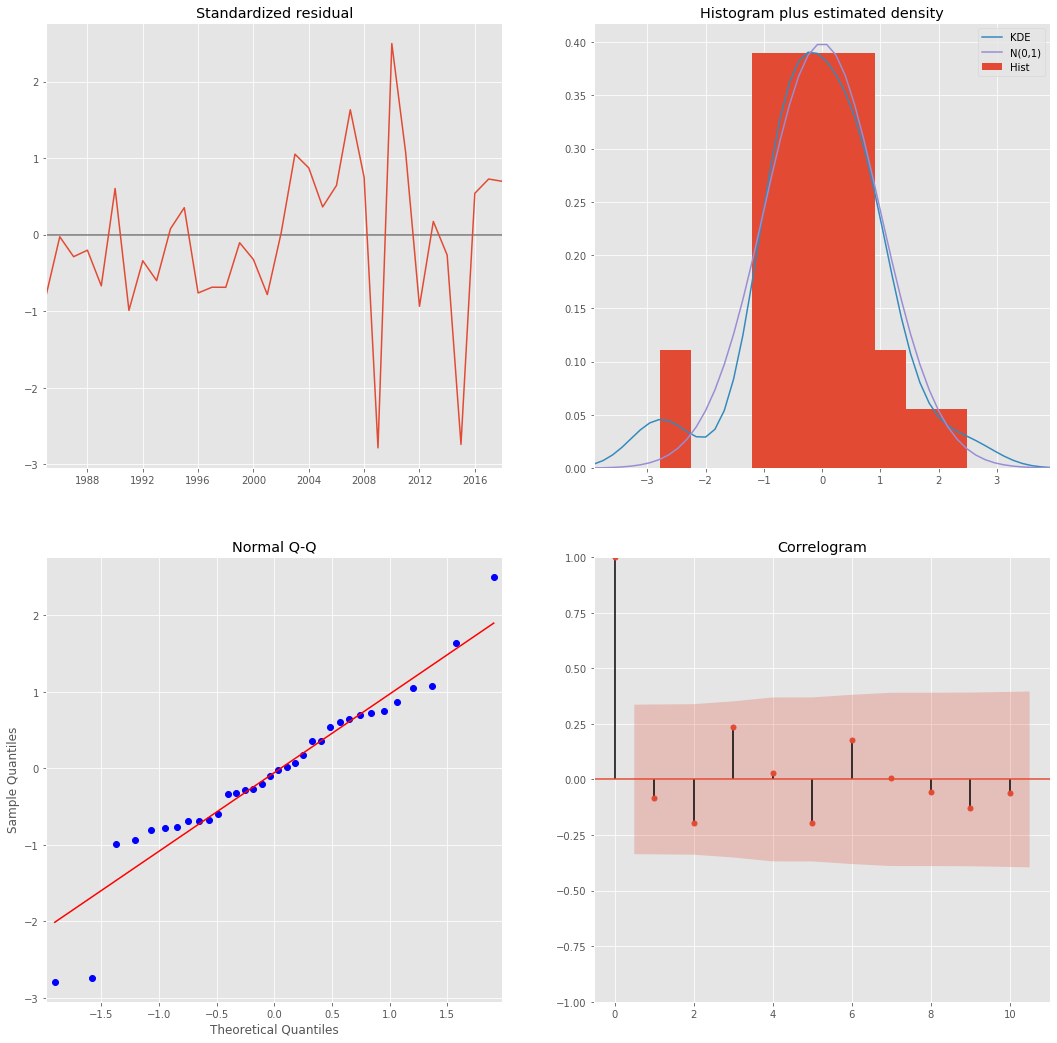

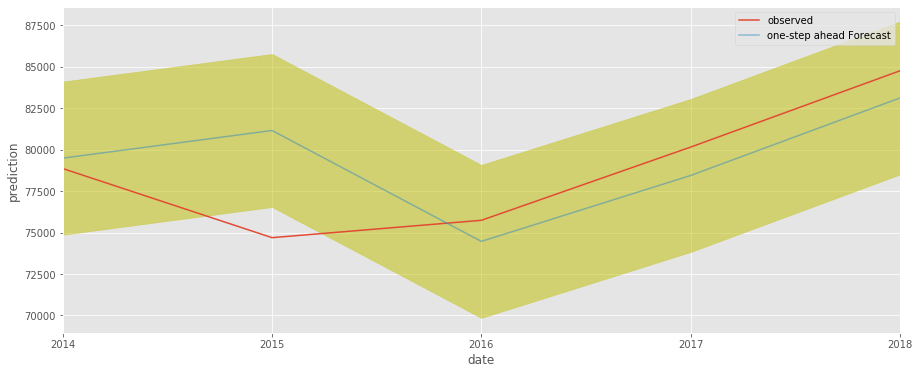

The Mean Squared Error is: 9860671.71
The Root Mean Squared Error is: 3140.17


In [103]:
analyse_series(world_gdp_train, 0, 2, 2, 2014)

# PREDICT WORLD_GROWTH

In [104]:
best_param(world_growth_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =196.27228945987454
ARIMA (0, 0, 0) : BIC Calculated =197.90987561960094
ARIMA (0, 0, 1) : AIC Calculated =167.7768945795683
ARIMA (0, 0, 1) : BIC Calculated =170.99873040485676
ARIMA (0, 0, 2) : AIC Calculated =155.70196866858103
ARIMA (0, 0, 2) : BIC Calculated =160.45252548394936
ARIMA (0, 1, 0) : AIC Calculated =140.42674545698554
ARIMA (0, 1, 0) : BIC Calculated =142.03766336962977
ARIMA (0, 1, 1) : AIC Calculated =124.25399713580633
ARIMA (0, 1, 1) : BIC Calculated =127.42103501271855
ARIMA (0, 1, 2) : AIC Calculated =120.0263536581579
ARIMA (0, 1, 2) : BIC Calculated =124.69239784262615
ARIMA (0, 2, 0) : AIC Calculated =171.30378677177234
ARIMA (0, 2, 0) : BIC Calculated =172.88730571022845
ARIMA (0, 2, 1) : AIC Calculated =136.1057788228356
ARIMA (0, 2, 1) : BIC Calculated =139.2164749458144
ARIMA (0, 2, 2) : AIC Calculated =125.3321553241814
ARIMA (0, 2, 2) : BIC Calculated =129.91123689802987
ARIMA (1, 0, 0) : AIC Calculated =143.0720028535017

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (1, 2, 2) : AIC Calculated =125.69600063807044
ARIMA (1, 2, 2) : BIC Calculated =131.80144273653508
ARIMA (2, 0, 0) : AIC Calculated =140.03182528577798
ARIMA (2, 0, 0) : BIC Calculated =144.86457902371066
ARIMA (2, 0, 1) : AIC Calculated =130.22251434759397
ARIMA (2, 0, 1) : BIC Calculated =136.66618599817087
ARIMA (2, 0, 2) : AIC Calculated =128.56939158821802
ARIMA (2, 0, 2) : BIC Calculated =136.4869862804986
ARIMA (2, 1, 0) : AIC Calculated =131.96362844745406
ARIMA (2, 1, 0) : BIC Calculated =136.71418526282238
ARIMA (2, 1, 1) : AIC Calculated =126.7197002158346
ARIMA (2, 1, 1) : BIC Calculated =133.05377596965906


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (2, 1, 2) : AIC Calculated =121.47121131421777
ARIMA (2, 1, 2) : BIC Calculated =129.24795162166484
ARIMA (2, 2, 0) : AIC Calculated =148.2761427745972
ARIMA (2, 2, 0) : BIC Calculated =152.94218695906542
ARIMA (2, 2, 1) : AIC Calculated =134.86270636721622
ARIMA (2, 2, 1) : BIC Calculated =141.08409861317386
ARIMA (2, 2, 2) : AIC Calculated =129.3273253372381
ARIMA (2, 2, 2) : BIC Calculated =136.95912796031894


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



(COMBINATION    (0, 1, 2)
 AIC              120.026
 Name: 5, dtype: object, COMBINATION    (0, 1, 2)
 BIC              124.692
 Name: 5, dtype: object)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:           WORLD_GROWTH   No. Observations:                   39
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -57.013
Date:                Thu, 25 Jul 2019   AIC                            120.026
Time:                        09:34:44   BIC                            124.692
Sample:                    01-01-1980   HQIC                           121.637
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7015   2841.100     -0.000      1.000   -5569.155    5567.752
ma.L2         -0.2985    847.917     -0.000      1.000   -1662.186    1661.589
sigma2         1.4075   3998.743      0.000      1.0

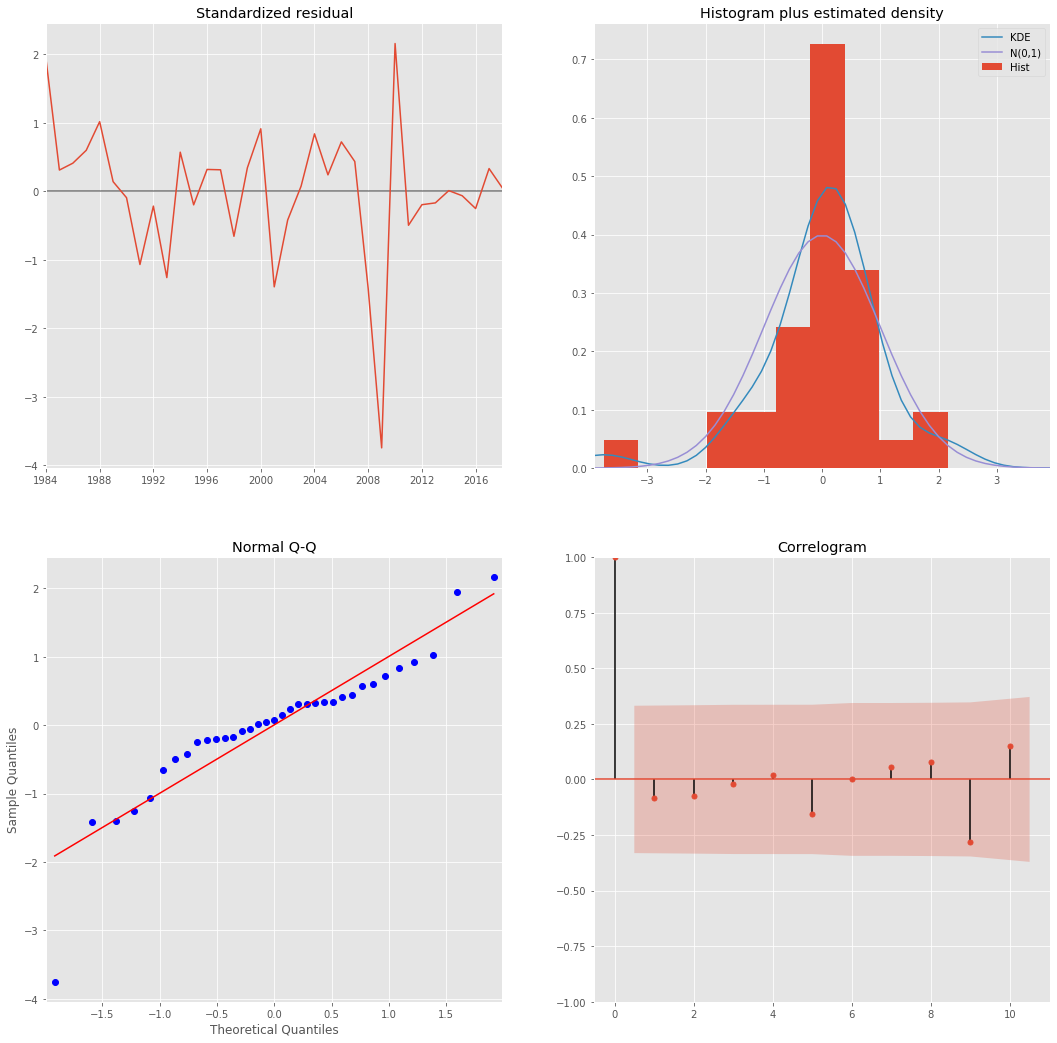

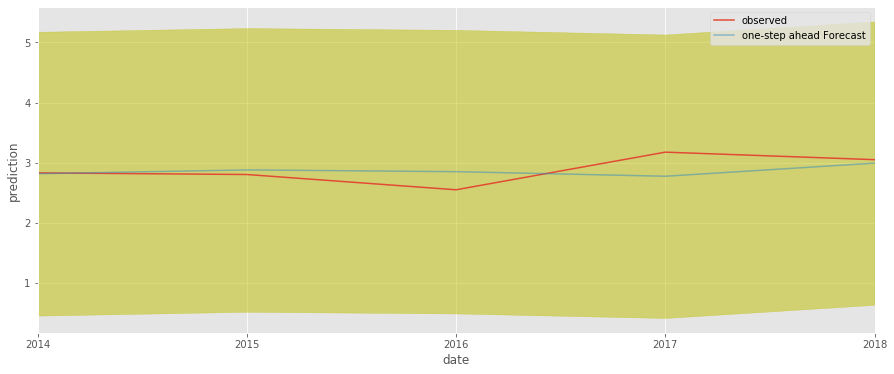

The Mean Squared Error is: 0.05
The Root Mean Squared Error is: 0.23


In [105]:
analyse_series(world_growth_train, 0, 1, 2, 2014)

# ADDITIONAL MODELING

In [66]:
a= us_gdp_train[:32]
b= us_gdp_train[32:]

In [67]:
a

YEAR
1980-01-01     2857.325
1981-01-01     3207.025
1982-01-01     3343.800
1983-01-01     3634.025
1984-01-01     4037.650
1985-01-01     4339.000
1986-01-01     4579.625
1987-01-01     4855.250
1988-01-01     5236.425
1989-01-01     5641.600
1990-01-01     5963.125
1991-01-01     6158.125
1992-01-01     6520.325
1993-01-01     6858.550
1994-01-01     7287.250
1995-01-01     7639.750
1996-01-01     8073.125
1997-01-01     8577.550
1998-01-01     9062.825
1999-01-01     9630.700
2000-01-01    10252.350
2001-01-01    10581.825
2002-01-01    10936.450
2003-01-01    11458.250
2004-01-01    12213.725
2005-01-01    13036.625
2006-01-01    13814.600
2007-01-01    14451.875
2008-01-01    14712.825
2009-01-01    14448.925
2010-01-01    14992.050
2011-01-01    15542.600
Name: US_GDP, dtype: float64

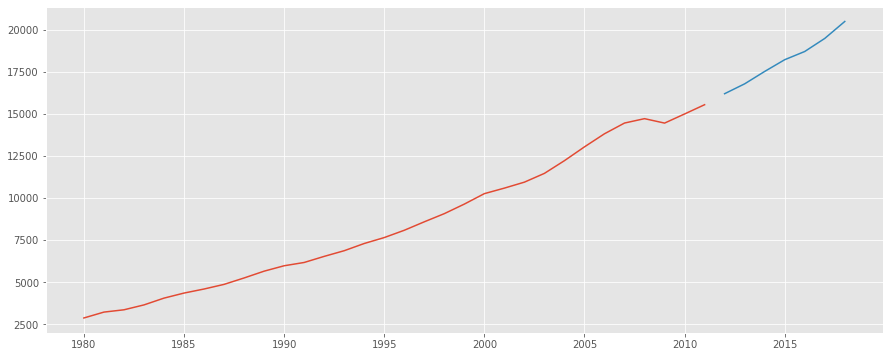

In [68]:
plt.plot(a)
plt.plot(b)

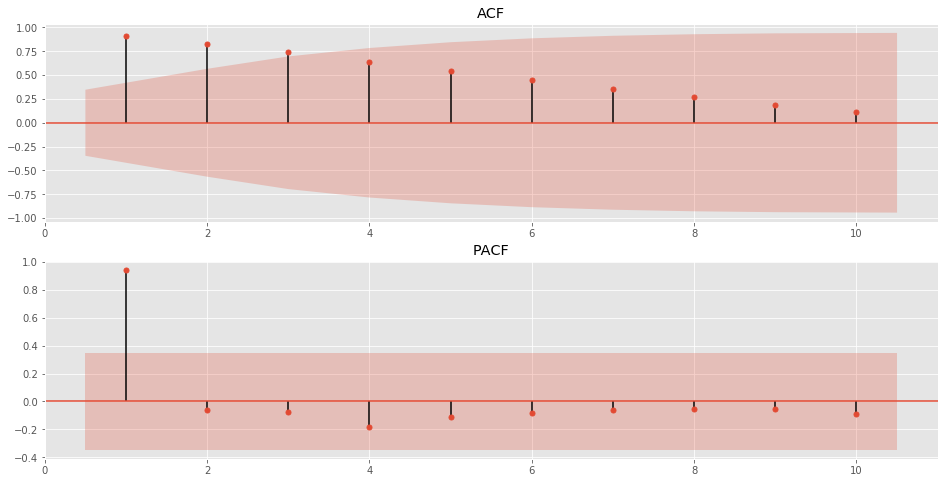

In [69]:
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(a, lags=10, title='ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(a, lags=10, title= 'PACF', zero= False, ax=ax2)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   32
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -211.872
Date:                Thu, 25 Jul 2019   AIC                            427.745
Time:                        09:20:44   BIC                            430.613
Sample:                    01-01-1980   HQIC                           428.680
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0435      0.006    179.771      0.000       1.032       1.055
sigma2      5.058e+04   1.18e+04      4.291      0.000    2.75e+04    7.37e+04
Ljung-Box (Q):                         nan   Jarque-

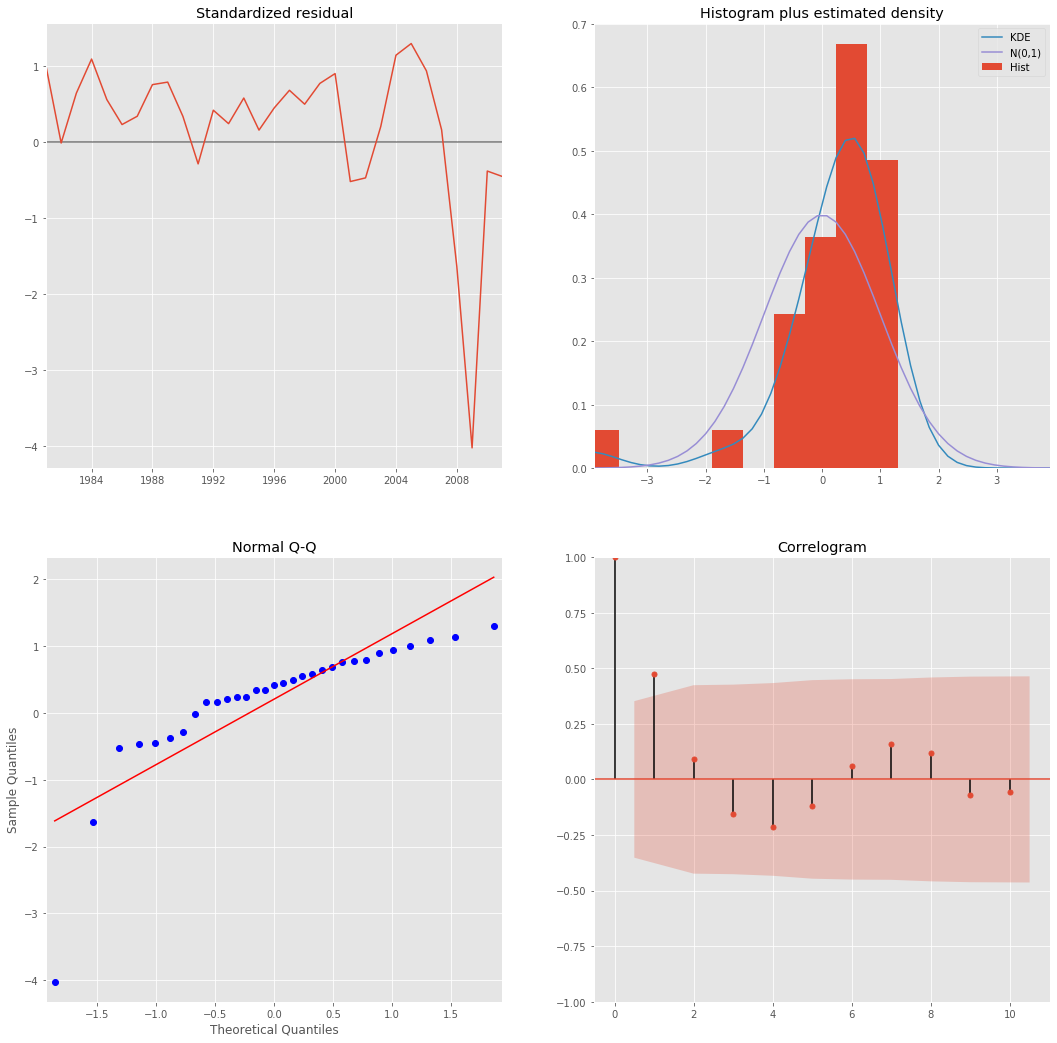

In [70]:
model= sm.tsa.statespace.SARIMAX(a,
                                order=(1, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output= model.fit()
print(output.summary())
output.plot_diagnostics(figsize=(18, 18))
plt.show()

In [71]:
c= output.get_prediction(start= '2012-01-01', end= '2018-01-01')

In [72]:
cp= c.predicted_mean

In [73]:
int_= c.conf_int(alpha= .05)

In [74]:
int_.index

DatetimeIndex(['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

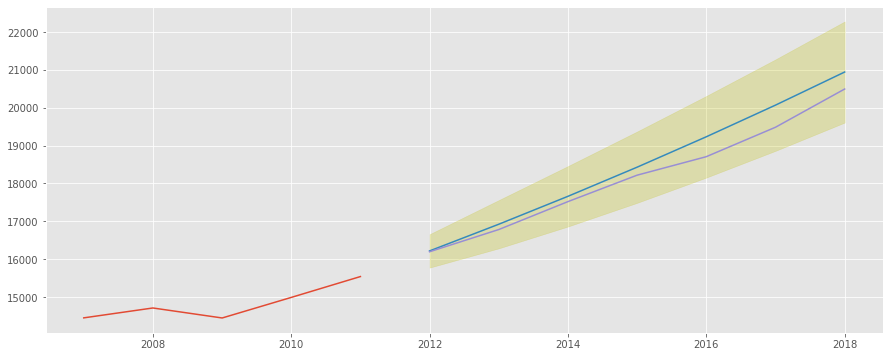

In [75]:
plt.plot(a[-5:])
plt.plot(cp)
plt.plot(b)
plt.fill_between(int_.index,
                int_.iloc[:, 0],
               int_.iloc[:, 1], color='y', alpha=.25)

In [76]:
np.sqrt(mean_squared_error(cp, b))

359.08978354873653

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -435.918
Date:                Thu, 25 Jul 2019   AIC                            875.836
Time:                        09:20:46   BIC                            879.058
Sample:                    01-01-1980   HQIC                           876.972
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.6882      0.171    -15.740      0.000      -3.023      -2.353
sigma2      1.467e+08   4.98e-10   2.94e+17      0.000    1.47e+08    1.47e+08
Ljung-Box (Q):                         nan   Jarque-

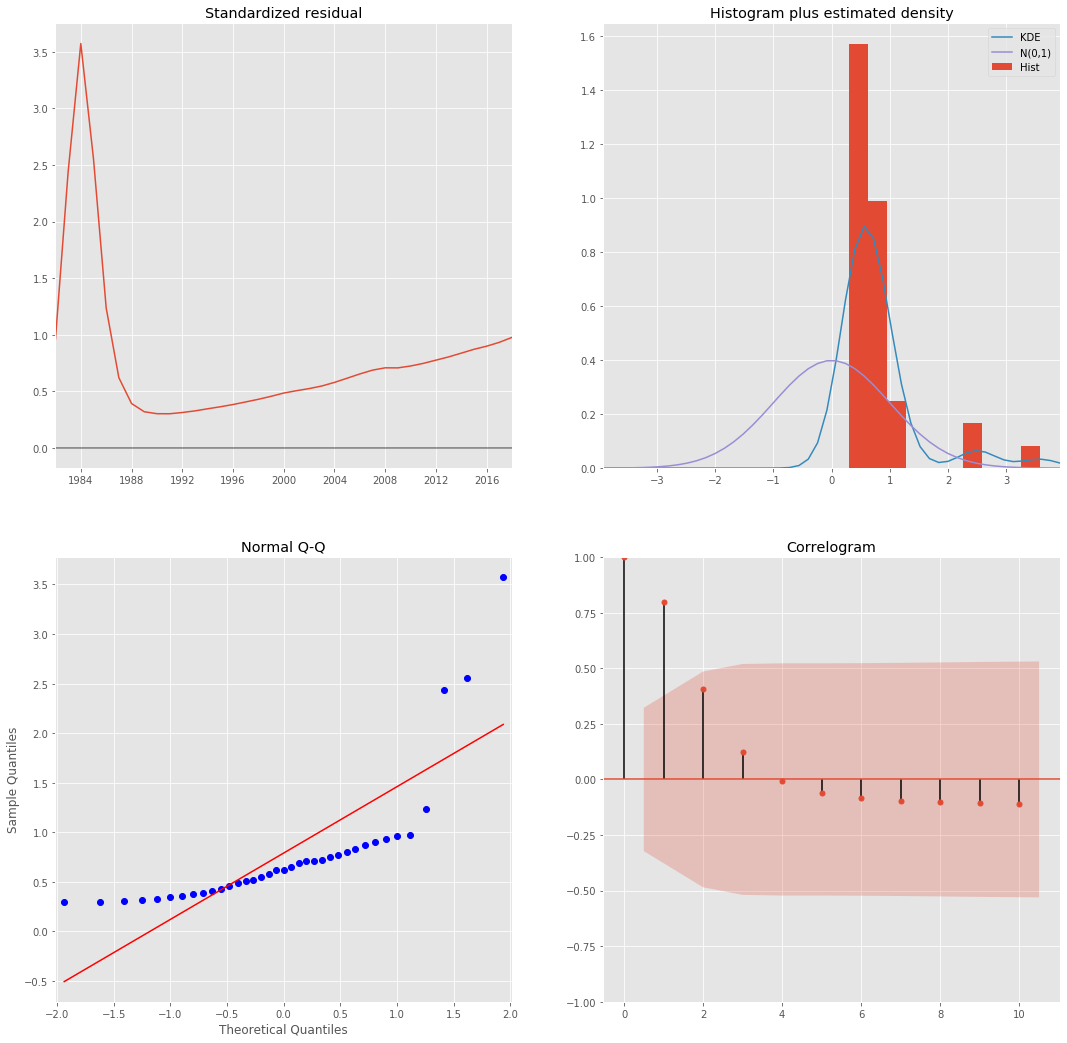

In [77]:
model= sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(0, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output= model.fit()
print(output.summary())
output.plot_diagnostics(figsize=(18, 18))
plt.show()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -245.648
Date:                Thu, 25 Jul 2019   AIC                            497.297
Time:                        09:20:48   BIC                            502.130
Sample:                    01-01-1980   HQIC                           499.001
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0422      0.005    218.085      0.000       1.033       1.052
ma.L1          0.4691      0.143      3.280      0.001       0.189       0.750
sigma2      3.414e+04   7446.172      4.585      0.0

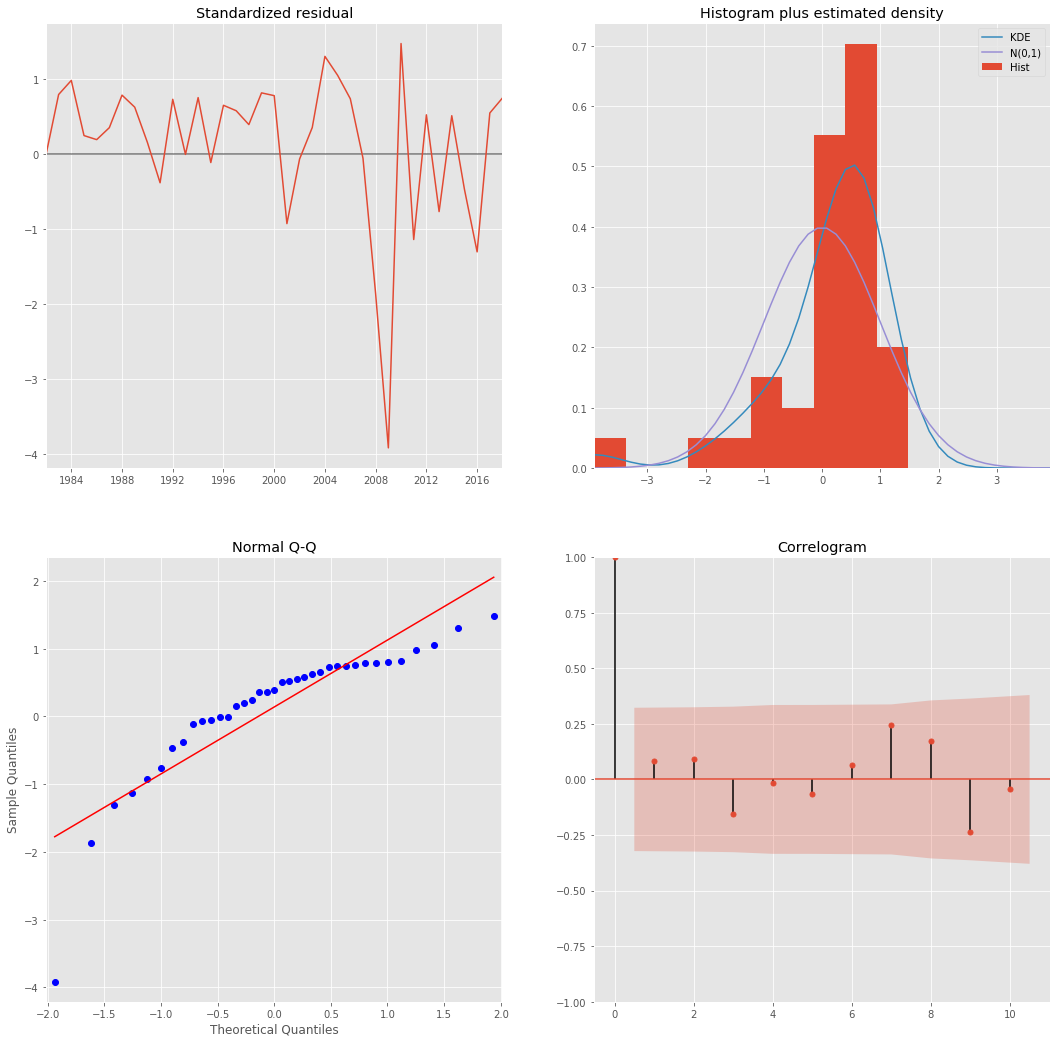

In [78]:
model= sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(1, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output= model.fit()
print(output.summary())
output.plot_diagnostics(figsize=(18, 18))
plt.show()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -242.045
Date:                Thu, 25 Jul 2019   AIC                            490.089
Time:                        09:20:49   BIC                            494.840
Sample:                    01-01-1980   HQIC                           491.747
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0253      0.007    148.050      0.000       1.012       1.039
ma.L1         -1.0000      0.151     -6.626      0.000      -1.296      -0.704
sigma2      3.739e+04   4.04e-06   9.26e+09      0.0

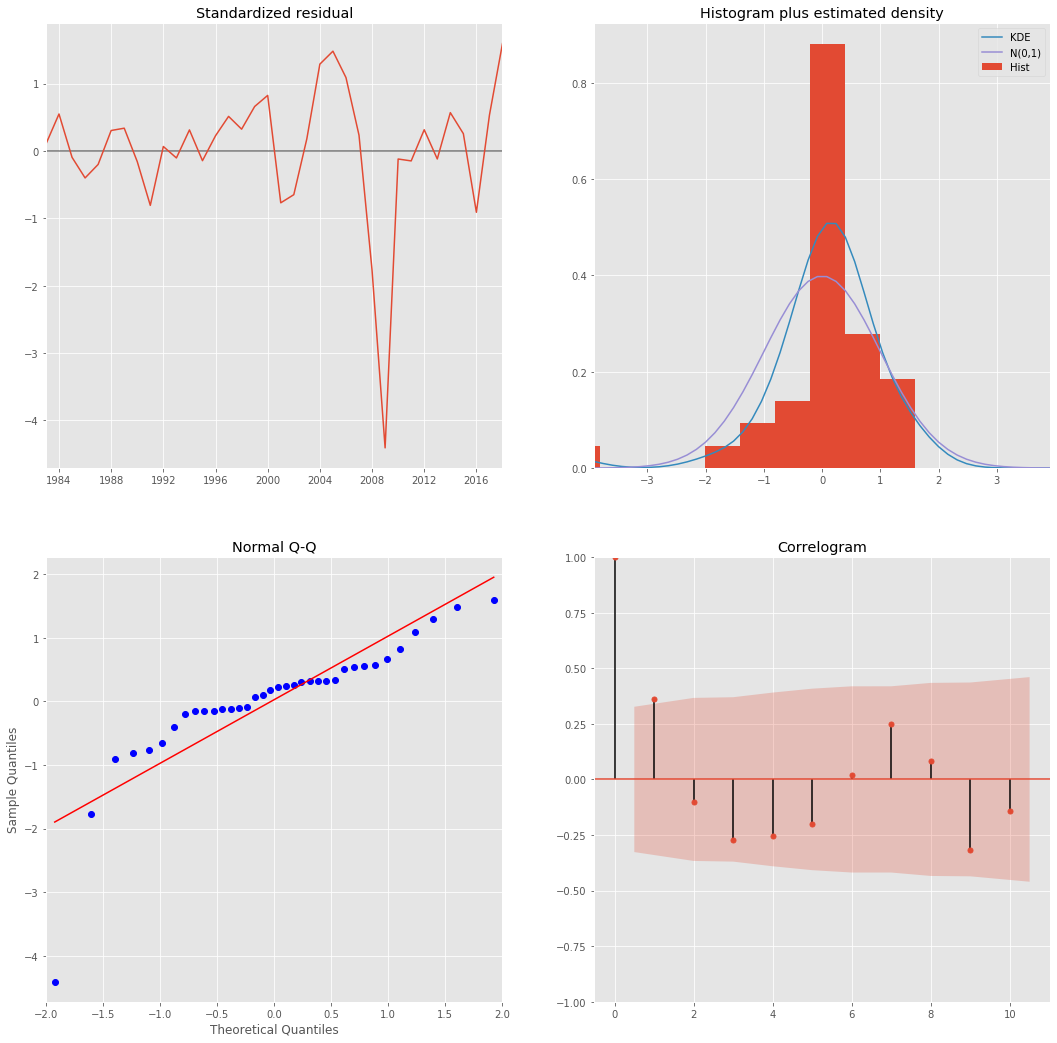

In [79]:
model= sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output= model.fit()
print(output.summary())
output.plot_diagnostics(figsize=(18, 18))
plt.show()